In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the data
df = pd.read_csv('../data/train_enc.csv')

In [ ]:
# Split the data into training and validation sets
train = df.sample(frac=0.8, random_state=200)
validation = df.drop(train.index)

print(train.shape)
print(validation.shape)

In [ ]:
# split the columns into features and target; ie x y split
target = 'SalePrice'
train_x = train.drop(target, axis=1)
train_y = train[target]

validation_x = validation.drop(target, axis=1)
validation_y = validation[target]

train_x.shape, train_y.shape, validation_x.shape, validation_y.shape

## Hyperparameter Tuning using Manual Search ie Trial and Error

In [ ]:
# Define the hyperparameters to try
n_estimators_options = [50, 100, 150, 200]
max_depth_options = [5, 10, 15, 20]

# Initialize a dictionary to store the r2 scores
scores = {}

# Loop over the hyperparameters
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        # Create the model with the current hyperparameters
        rfr_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)

        # Fit the model
        rfr_model.fit(train_x, train_y)

        # Make predictions
        validation_predictions = rfr_model.predict(validation_x)

        # Calculate and print the r squared error
        score = r2_score(validation_y, validation_predictions)
        print(f'n_estimators: {n_estimators}, max_depth: {max_depth}, r2_score: {score}')
        
        # Store the r squared error in the dictionary
        scores[(n_estimators, max_depth)] = score

In [ ]:
# Convert the dictionary to a DataFrame
df_scores = pd.DataFrame(list(scores.items()), columns=['Tuple', 'r2_score'])

# Split the 'Tuple' column into two separate columns
df_scores[['n_estimators', 'max_depth']] = pd.DataFrame(df_scores['Tuple'].tolist(), index=df_scores.index)

# Drop the original 'Tuple' column
df_scores.drop(columns=['Tuple'], inplace=True)

# Display the DataFrame
df_scores

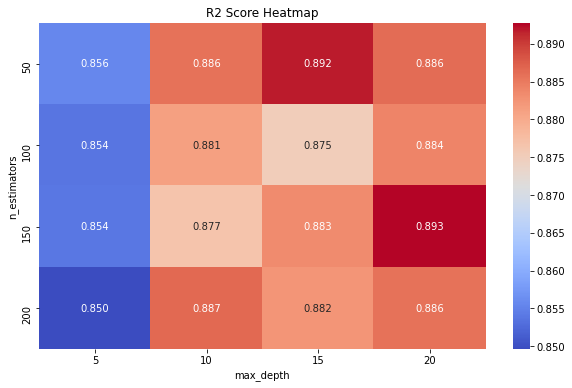

In [32]:
# Plot the r2 scores
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_scores.pivot('n_estimators', 'max_depth', 'r2_score'), annot=True, fmt='.3f', cmap='coolwarm', ax=ax)
ax.set_title('R2 Score Heatmap')
plt.show()

The best hyperparameters are n_estimators=150 and max_depth=20

## Trying Grid Search for a more systematic approach

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to try
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20]
}

# Create the model
rfr_model = RandomForestRegressor()

# Create the grid search object
grid_search = GridSearchCV(estimator=rfr_model, param_grid=param_grid, cv=5, scoring='r2')

# Fit the grid search object to the data
grid_search.fit(train_x, train_y)

# Get the best hyperparameters
best_hyperparameters = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

print(f'Best hyperparameters: {best_hyperparameters}, Best r2 score: {best_score}')

Grid Search produced different results. According to it, max_depth=15 and n_estimators=100 are the best hyperparameters with a r2 score of 0.85. I got 0.89 r2 score with n_estimators=150 and max_depth=20 with manual search. 

Going to repeat the process with the best hyperparameters 20 times from the manual search to see if it is consistent.

In [ ]:
# Create the model with the best hyperparameters
rfr_model = RandomForestRegressor(n_estimators=150, max_depth=20)

#run the model 20 times and plot the r2 scores
r2_scores = []
for i in range(20):
    # Fit the model
    rfr_model.fit(train_x, train_y)

    # Make predictions
    validation_predictions = rfr_model.predict(validation_x)

    # Calculate and print the r squared error
    score = r2_score(validation_y, validation_predictions)
    print(score)
    r2_scores.append(score)

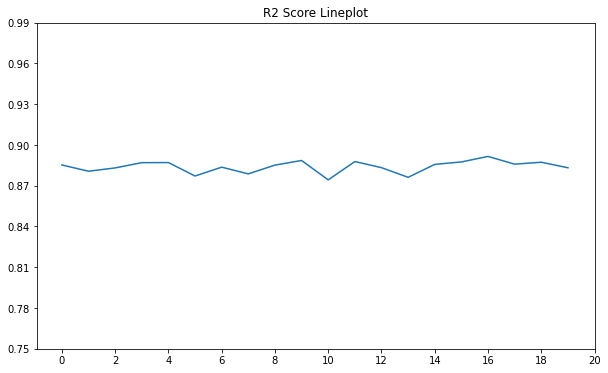

In [58]:
# Plot the r2 scores to show consistency
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(20), y=r2_scores, ax=ax)
ax.set_title('R2 Score Lineplot')
ax.set_ylim(0.75, 0.95)
ax.set_xticks(range(0, 21, 2))
ax.set_yticks(np.arange(0.75, 1.0, 0.03))
plt.show()

#### The r2 scores are consistent, hovering around 0.88-0.89. This means the hyperparameters are stable and the model is consistent.